# Trial 1


In [ ]:
import cv2
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import scipy
from scipy import signal

# Load the image
img_1 = cv2.imread('CASIA-Iris-Image-Database-Sample-Images.png')
col_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img_1)
ax[0].set_title("original iris")
ax[1].imshow(col_img_1)
ax[1].set_title("color iris")

# Iris localization
blur_img_1 = cv2.bilateralFilter(col_img_1, 9, 75, 75)

horizontalProjection = np.mean(blur_img_1, 0)
verticalProjection = np.mean(blur_img_1, 1)
center_x = horizontalProjection.argmin()
center_y = verticalProjection.argmin()

centrecrop_x = blur_img_1[center_x - 60:center_x + 60]
centrecrop_y = blur_img_1[center_y - 60:center_y + 60]

horizontalProjection = np.mean(centrecrop_y, 0)
verticalProjection = np.mean(centrecrop_x, 0)

crop_center_x = horizontalProjection.argmin()
crop_center_y = verticalProjection.argmin()

cimg = blur_img_1.copy()
cv2.circle(cimg, (crop_center_x, crop_center_y), 1, (255, 0, 0), 2)

# Apply Canny edge detector on the masked image
maskimage = cv2.inRange(blur_img_1, 0, 70)
output = cv2.bitwise_and(blur_img_1, maskimage)
edged = cv2.Canny(output, 100, 220)

# Apply Hough transform to find potential boundaries of pupil
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)

# Define the center of the pupil
a = (crop_center_x, crop_center_y)

out = blur_img_1.copy()
min_dst = math.inf

for i in circles[0]:
    b = (i[0], i[1])
    dst = distance.euclidean(a, b)
    if dst < min_dst:
        min_dst = dst
        k = i

# Draw the inner boundary
localized_img_1 = cv2.circle(col_img_1, (int(k[0]), int(k[1])), int(k[2]), (255, 0, 0), 3)

# Draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary
radius_pupil = int(k[2])
localized_img_1 = cv2.circle(col_img_1, (int(k[0]), int(k[1])), radius_pupil + 53, (255, 0, 0), 3)

centers = [k[0], k[1], k[2]]

# IRIS normalization
center_x = centers[0]
center_y = centers[1]
radius_pupil = int(centers[2])

iris_radius = 53
im = localized_img_1
nsamples = 360
samples = np.linspace(0, 2 * np.pi, nsamples)[:-1]
polar = np.zeros((iris_radius, nsamples))

for r in range(iris_radius):
    for theta in samples:
        x = (r + radius_pupil) * np.cos(theta) + center_x
        y = (r + radius_pupil) * np.sin(theta) + center_y
        x = int(x)
        y = int(y)
        try:
            polar[r][int((theta * nsamples) / (2 * np.pi))] = im[y][x]
        except IndexError:
            pass

normalized = cv2.resize(polar, (512, 64))

# Image enhancement
enhanced = []
for res in normalized:
    res = res.astype(np.uint8)
    im = cv2.equalizeHist(res)
    enhanced.append(im)

# Feature extraction
def m(x, y, f):
    val = np.cos(2 * np.pi * f * math.sqrt(x ** 2 + y ** 2))
    return val

def gabor(x, y, dx, dy, f):
    gb = (1 / (2 * math.pi * dx * dy)) * np.exp(-0.5 * (x ** 2 / dx ** 2 + y ** 2 / dy ** 2)) * m(x, y, f)
    return gb

def spatial(f, dx, dy):
    sfilter = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            sfilter[i, j] = gabor((-4 + j), (-4 + i), dx, dy, f)
    return sfilter

def get_vec(convolvedtrain1, convolvedtrain2):
    feature_vec = []
    for i in range(6):
        for j in range(64):
            start_height = i * 8
            end_height = start_height + 8
            start_wid = j * 8
            end_wid = start_wid + 8
            grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
            grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]
            absolute = np.absolute(grid1)
            mean = np.mean(absolute) if absolute.size > 0 else 0
            feature_vec.append(mean)
            std = np.mean(np.absolute(absolute - mean)) if absolute.size > 0 else 0
            feature_vec.append(std)
            absolute = np.absolute(grid2)
            mean = np.mean(absolute) if absolute.size > 0 else 0
            feature_vec.append(mean)
            std = np.mean(np.absolute(absolute - mean)) if absolute.size > 0 else 0
            feature_vec.append(std)
    return feature_vec

con1 = []
con2 = []
filter1 = spatial(0.67, 3, 1.5)
filter2 = spatial(0.67, 4, 1.5)
feature_vector = []

for i in range(len(enhanced)):
    img = enhanced[i]
    img_roi = img[:48, :]
    filtered1 = scipy.signal.convolve2d(img_roi, filter1, mode='same')
    filtered2 = scipy.signal.convolve2d(img_roi, filter2, mode='same')
    con1.append(filtered1)
    con2.append(filtered2)
    fv = get_vec(filtered1, filtered2)
    feature_vector.append(fv)

# Now, feature_vector contains the feature vectors for each image.
# You can use these feature vectors for further steps such as matching and recognition.

# Example: Print the feature vectors
for i, fv in enumerate(feature_vector):
    print(f"Feature Vector for Image {i+1}: {fv}")

plt.show()  # Show the plots


# Working Version

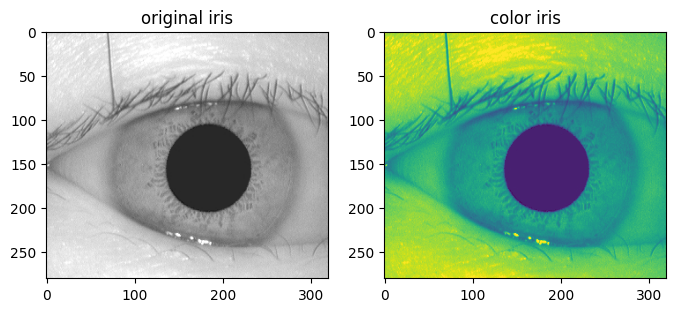

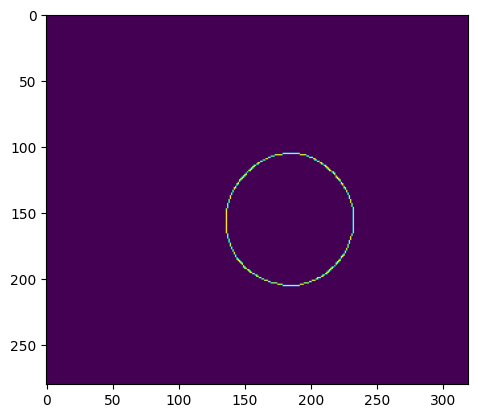

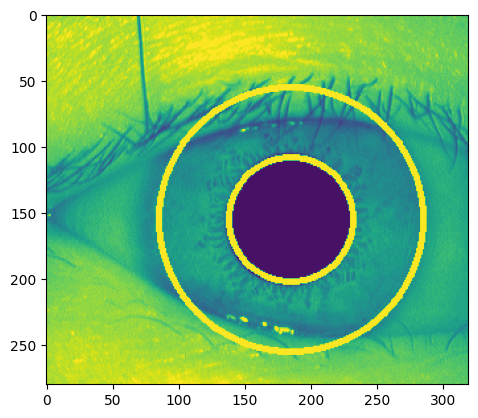

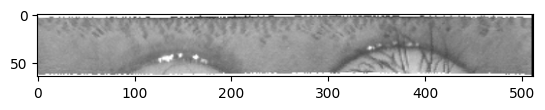

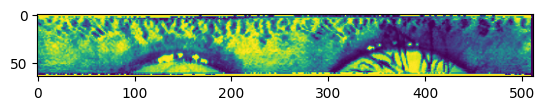

Feature Vector for Image 1: [3.3783299550617647, 0.9500928124841155, 2.596086125067025, 0.7301012040935544, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3.517568061263672, 0.0, 2.7030839969148532, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
import cv2
import numpy as np
import math
from scipy.spatial import distance
import matplotlib.pyplot as plt
import scipy
from scipy import signal

# Load the image
img_1 = cv2.imread('CASIA-Iris-Image-Database-Sample-Images.png')
col_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)

# Display the original and grayscale images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].imshow(img_1)
ax[0].set_title("original iris")
ax[1].imshow(col_img_1)
ax[1].set_title("color iris")
plt.show()

# Iris localization
blur_img_1 = cv2.bilateralFilter(col_img_1, 9, 75, 75)

horizontalProjection = np.mean(blur_img_1, 0)
verticalProjection = np.mean(blur_img_1, 1)
center_x = horizontalProjection.argmin()
center_y = verticalProjection.argmin()

centrecrop_x = blur_img_1[center_x - 60:center_x + 60]
centrecrop_y = blur_img_1[center_y - 60:center_y + 60]

horizontalProjection = np.mean(centrecrop_y, 0)
verticalProjection = np.mean(centrecrop_x, 0)

crop_center_x = horizontalProjection.argmin()
crop_center_y = verticalProjection.argmin()

cimg = blur_img_1.copy()
cv2.circle(cimg, (crop_center_x, crop_center_y), 1, (255, 0, 0), 2)

# Apply Canny edge detector on the masked image
maskimage = cv2.inRange(blur_img_1, 0, 70)
output = cv2.bitwise_and(blur_img_1, maskimage)
edged = cv2.Canny(output, 100, 220)

# Display the Canny edge detector result
plt.imshow(edged)
plt.show()

# Apply Hough transform to find potential boundaries of pupil
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)

# Define the center of the pupil
a = (crop_center_x, crop_center_y)

out = blur_img_1.copy()
min_dst = math.inf

for i in circles[0]:
    b = (i[0], i[1])
    dst = distance.euclidean(a, b)
    if dst < min_dst:
        min_dst = dst
        k = i

# Draw the inner boundary
localized_img_1 = cv2.circle(col_img_1, (int(k[0]), int(k[1])), int(k[2]), (255, 0, 0), 3)

# Draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary
radius_pupil = int(k[2])
localized_img_1 = cv2.circle(col_img_1, (int(k[0]), int(k[1])), radius_pupil + 53, (255, 0, 0), 3)

# Display the localized iris image
plt.imshow(localized_img_1)
plt.show()

centers = [k[0], k[1], k[2]]

# IRIS normalization
center_x = centers[0]
center_y = centers[1]
radius_pupil = int(centers[2])

iris_radius = 53
im = localized_img_1
nsamples = 360
samples = np.linspace(0, 2 * np.pi, nsamples)[:-1]
polar = np.zeros((iris_radius, nsamples))

for r in range(iris_radius):
    for theta in samples:
        x = (r + radius_pupil) * np.cos(theta) + center_x
        y = (r + radius_pupil) * np.sin(theta) + center_y
        x = int(x)
        y = int(y)
        try:
            polar[r][int((theta * nsamples) / (2 * np.pi))] = im[y][x]
        except IndexError:
            pass

normalized = cv2.resize(polar, (512, 64))

# Display the normalized iris image
plt.imshow(normalized, cmap=plt.cm.gray)
plt.show()

# Image enhancement
enhanced = []
for res in normalized:
    res = res.astype(np.uint8)
    im = cv2.equalizeHist(res)
    enhanced.append(im)

# Display the enhanced iris image
plt.imshow(enhanced)
plt.show()

# Feature extraction
def m(x, y, f):
    val = np.cos(2 * np.pi * f * math.sqrt(x ** 2 + y ** 2))
    return val

def gabor(x, y, dx, dy, f):
    gb = (1 / (2 * math.pi * dx * dy)) * np.exp(-0.5 * (x ** 2 / dx ** 2 + y ** 2 / dy ** 2)) * m(x, y, f)
    return gb

def spatial(f, dx, dy):
    sfilter = np.zeros((8, 8))
    for i in range(8):
        for j in range(8):
            sfilter[i, j] = gabor((-4 + j), (-4 + i), dx, dy, f)
    return sfilter

def get_vec(convolvedtrain1, convolvedtrain2):
    feature_vec = []
    for i in range(6):
        for j in range(64):
            start_height = i * 8
            end_height = start_height + 8
            start_wid = j * 8
            end_wid = start_wid + 8
            grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
            grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]
            absolute = np.absolute(grid1)
            mean = np.mean(absolute) if absolute.size > 0 else 0
            feature_vec.append(mean)
            std = np.mean(np.absolute(absolute - mean)) if absolute.size > 0 else 0
            feature_vec.append(std)
            absolute = np.absolute(grid2)
            mean = np.mean(absolute) if absolute.size > 0 else 0
            feature_vec.append(mean)
            std = np.mean(np.absolute(absolute - mean)) if absolute.size > 0 else 0
            feature_vec.append(std)
    return feature_vec

con1 = []
con2 = []
filter1 = spatial(0.67, 3, 1.5)
filter2 = spatial(0.67, 4, 1.5)
feature_vector = []

for i in range(len(enhanced)):
    img = enhanced[i]
    img_roi = img[:48, :]
    filtered1 = scipy.signal.convolve2d(img_roi, filter1, mode='same')
    filtered2 = scipy.signal.convolve2d(img_roi, filter2, mode='same')
    con1.append(filtered1)
    con2.append(filtered2)
    fv = get_vec(filtered1, filtered2)
    feature_vector.append(fv)

# Now, feature_vector contains the feature vectors for each image.
# You can use these feature vectors for further steps such as matching and recognition.

# Example: Print the feature vectors
for i, fv in enumerate(feature_vector):
    print(f"Feature Vector for Image {i+1}: {fv}")

plt.show()  # Show the plots
